In [78]:
import torch
import numpy as np
from hysteresis.base import TorchHysteresis
from hysteresis.training import train_torch
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

In [79]:
fname = 'D:/SLAC/hysteresis/magnet_characterization/1.26Q3.5_4034/strplt.ru1'

data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double() * np.where(data[:,7] < 0, -1, 1)

# normalize h, m
h = (h - torch.min(h)) / (torch.max(h) - torch.min(h))
m = ((m - torch.mean(m)) / (max(m) - min(m)))*2.0 - 1.0

slope = (torch.max(m) - torch.min(m)) / \
        (torch.max(h) - torch.min(h))
scale = torch.std(m - slope * h - torch.min(m)) ** -1

def transform_m(m):
    return (m - slope * h - torch.min(m)) * scale
m = transform_m(m)

n_train = 60
h_train = h[:n_train]
m_train = m[:n_train]


In [80]:
# fit using normal hysteresis model
H = TorchHysteresis(h_train, mesh_scale = 0.05)

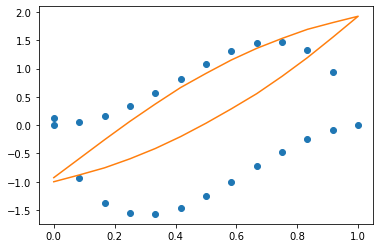

In [81]:
fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H.predict_magnetization_from_applied_fields().detach())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
tensor(0.0003, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
Parameter containing:
tensor([5.9898], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([5.9271], dtype=torch.float64, requires_grad=True)


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_34308/1438081651.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


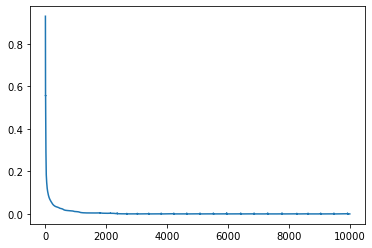

In [82]:
# train on data
loss_trace = train_torch(H, m_train, 10000, lr=0.1, atol=1e-8)
fig, ax = plt.subplots()
ax.plot(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)

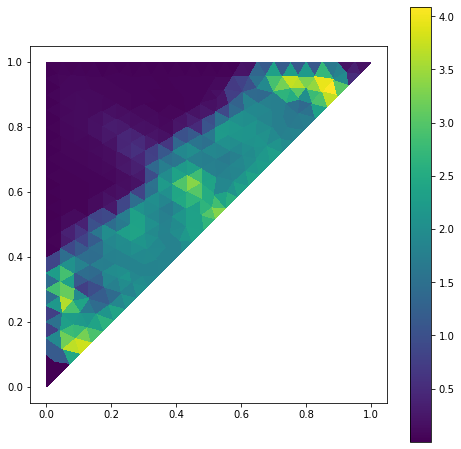

In [83]:
fig, ax = plot_hysteresis_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

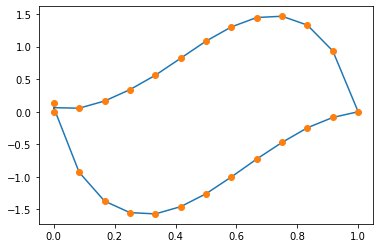

In [84]:
def fit(x):
    return 2.0*x - 1.0

fig, ax = plt.subplots()
m_pred = H.predict_magnetization_from_applied_fields()
ax.plot(h_train, m_pred.detach() )
ax.plot(h_train, m_train,'o')



In [85]:
print(H.offset)
print(H.scale)

Parameter containing:
tensor([5.9898], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([5.9271], dtype=torch.float64, requires_grad=True)


[iteration 0001] loss: 1922777.2986
[iteration 0101] loss: 3905.4099
[iteration 0201] loss: 3886.1384
[iteration 0301] loss: 3763.3199
[iteration 0401] loss: 3787.2273
[iteration 0501] loss: 3779.7579
[iteration 0601] loss: 3718.6335
[iteration 0701] loss: 3690.6843
[iteration 0801] loss: 3732.5389
[iteration 0901] loss: 3631.8690
[iteration 1001] loss: 3660.3114
[iteration 1101] loss: 3649.3337
[iteration 1201] loss: 3583.5849
[iteration 1301] loss: 3560.0441
[iteration 1401] loss: 3582.2376
[iteration 1501] loss: 3484.6191
[iteration 1601] loss: 3501.7468
[iteration 1701] loss: 3506.3023
[iteration 1801] loss: 3419.4364
[iteration 1901] loss: 3422.7122
[iteration 2001] loss: 3437.9073
[iteration 2101] loss: 3363.8819
[iteration 2201] loss: 3387.7773
[iteration 2301] loss: 3407.4715
[iteration 2401] loss: 3327.9642
[iteration 2501] loss: 3346.7156
[iteration 2601] loss: 3359.1030
[iteration 2701] loss: 3299.7558
[iteration 2801] loss: 3325.0702
[iteration 2901] loss: 3346.6727
[iterat

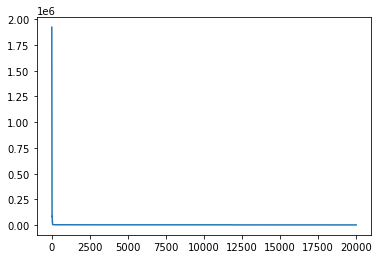

In [88]:


#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import map_bayes, train_bayes

def cov(model):
    return positional_covariance(model, 1.0)

bh = BayesianHysteresis(H, kernel_function=cov)
guide, trace = map_bayes(h_train, m_train, bh, 20000, initial_lr=0.1)
plt.plot(trace)


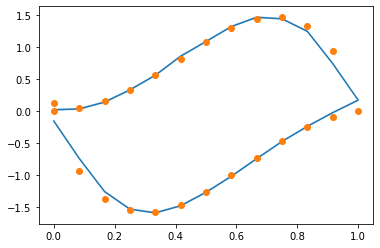

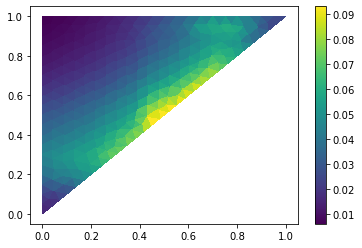

In [89]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density
pred_summary, samples = predict(h_train, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fig, ax = plt.subplots()
ax.plot(h_train, mean.detach())
ax.plot(h_train, m_train,'o')
ax.fill_between(h_train, l, u, alpha=0.25)


fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['mean'].flatten().detach())
)